# CLASSIFICADOR DE CEL·LULES CANCERIGENES BENIGNES / MALIGNES

## IMPORTS NECESSARIS


In [1]:

from imutils import paths
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import time
from skimage import io,color,exposure
from sklearn.model_selection import train_test_split


## Carregar imatges

In [2]:
def llegir_imatges(ruta):
    '''
    ruta = ruta de cada carpeta on estan colocades les imatges
    return = array numpy amb totes les imatges de la carpeta
    Comentat hi ha la opció de fer-ho en arrays de numpy, no se si serà necessari per optimitzar temps
    '''
    carpeta = os.listdir(ruta)
    llista = []
    for imatge in carpeta:
        ruta_imatge = os.path.join(ruta,imatge)
        img = Image.open(ruta_imatge)
        llista.append(img)
    return llista

def llegir_imatges_mal(ruta):
    '''
    ruta = ruta de cada carpeta on estan colocades les imatges
    return = array numpy amb totes les imatges de la carpeta
    Comentat hi ha la opció de fer-ho en arrays de numpy, no se si serà necessari per optimitzar temps
    '''
    carpeta = os.listdir(ruta)
    llista = []
    for imatge in carpeta:
        ruta_imatge = os.path.join(ruta,imatge)
        img = Image.open(ruta_imatge)
        llista.append(img)
    return llista[:200]

ruta_cel_benignes = "./Benign/"
ruta_cel_malignes_ProB = "./[Malignant] Pro-B/"
ruta_cel_malignes_PreB = "./[Malignant] Pre-B/"
ruta_cel_malignes_early_PreB = "./[Malignant] early Pre-B/"

benignes = llegir_imatges(ruta_cel_benignes)
proB = llegir_imatges(ruta_cel_malignes_ProB)
preB = llegir_imatges(ruta_cel_malignes_PreB)
early_preB = llegir_imatges(ruta_cel_malignes_early_PreB)

print("Numero de samples de cada carpeta:")
print("Benignes: ", len(benignes))
print("ProB: ", len(proB))
print("PreB: ", len(preB))
print("early_PreB", len(early_preB))

Numero de samples de cada carpeta:
Benignes:  512
ProB:  796
PreB:  955
early_PreB 979


### S'haurà de fer un tractament de dades, hi ha moltes menys benignes que de qualsevol altre tipus

#### Etiqueto i barrejo les imatges per tal de poder fer els diferents conjunts d'entrenament, de moment com que benignes es el que menys imatges té, posare tante imatges com benignes tinc de cada carpeta

In [3]:
llista_etiquetades = []

for i in range(len(benignes)):
    llista_etiquetades.append([benignes[i],'ben'])

for i in range(200):
    llista_etiquetades.append([proB[i],'mal'])
    llista_etiquetades.append([preB[i],'mal'])
    llista_etiquetades.append([early_preB[i],'mal'])

for i in range(4):
  print(llista_etiquetades[i][-1])
print(len(llista_etiquetades))

random.shuffle(llista_etiquetades)



ben
ben
ben
ben
1112


### Separem la llista de imatges i etiquetes i les posem en 2 dataframes, un sera pel test i l'altre pel train

In [4]:
paths, labels = zip(*llista_etiquetades)

train_paths, test_paths, train_labels, test_labels = train_test_split(paths, labels, test_size=0.2, random_state=42)

train = pd.DataFrame({'Path': train_paths, 'Label': train_labels})
test = pd.DataFrame({'Path': test_paths, 'Label': test_labels})

print("Number of training samples:", len(train))
print("Number of testing samples:", len(test))

print("Example training sample path:", train.iloc[0]['Path'])
print("Example training sample label:", train.iloc[0]['Label'])


print(test.shape)

Number of training samples: 889
Number of testing samples: 223
Example training sample path: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1F80D517A90>
Example training sample label: mal
(223, 2)


In [5]:
import pickle
def save_features_labels(features, labels, filename):
    with open(filename, 'wb') as f:
        pickle.dump((features, labels), f)

def load_features_labels(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

train_features = []
train_labels =[]
test_features = []
test_labels =[]
train_features, train_labels = load_features_labels('train_features_labels_lbp_bi_train.pkl')

test_features, test_labels = load_features_labels('test_features_labels_lbp_bi_test.pkl')


##### Aqui tenim els primers classificadors implementats, son classificadors més simples i no s'obtenen uns resultats lo suficientment precissos com per considerarlo adequat  al reconeixement de celules beninges o malignes.

In [6]:
from math import radians
import os
import numpy as np
from skimage import io, color, img_as_ubyte
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import classification_report
# LBP
radi = 3
n_p = 8 * radi

def extract_lbp_features(gray_image):
    lbp = local_binary_pattern(gray_image, n_p, radi, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_p + 3), range=(0, n_p + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

#SI EXISTEIX TRAIN_FEATURES I ESTA BUIT FEM EL EXTRACT FEATURES, SI NO L'HEM CARREGADA 
if len(train_features) == 0 or len(train_labels) == 0:
  train_features = []
  train_labels = []

  for index, row in train.iterrows():
      image_path = row['Path'].filename
      label = row['Label']
      if os.path.exists(image_path):
          image = img_as_ubyte(io.imread(image_path))
          gray_image = color.rgb2gray(image)
          lbp_features = extract_lbp_features(gray_image)
          train_features.append(lbp_features)
          train_labels.append(label)
      else:
          print(f"Image not found at path: {image_path}")

  #prova d'entrenament amb resultat amb només train
  train_features = np.array(train_features)
  train_labels = np.array(train_labels)
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# SVC
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Train Accuracy:", accuracy)

#Test
if len(train_features) == 0 or len(train_labels) == 0:
  test_features = []
  test_labels = []

  for index, row in test.iterrows():
      image_path = row['Path'].filename
      label = row['Label']
      if os.path.exists(image_path):
          image = img_as_ubyte(io.imread(image_path))
          gray_image = color.rgb2gray(image)
          lbp_features = extract_lbp_features(gray_image)
          test_features.append(lbp_features)
          test_labels.append(label)
      else:
          print("Error")


test_features = np.array(test_features)
test_labels = np.array(test_labels)
test_predictions = svm_classifier.predict(test_features)

test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

#RANDOM FOREST
# Crear y entrenar el clasificador Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_features, train_labels)

# Realizar predicciones en el conjunto de prueba
test_predictions_rf = rf_classifier.predict(test_features)

# Calcular y mostrar la precisión del Random Forest
test_accuracy_rf = accuracy_score(test_labels, test_predictions_rf)
print("Test Accuracy with Random Forest:", test_accuracy_rf)
print(classification_report(test_labels, test_predictions_rf))

Train Accuracy: 0.6348314606741573
Test Accuracy: 0.6233183856502242
Test Accuracy with Random Forest: 0.8878923766816144
              precision    recall  f1-score   support

         ben       0.88      0.84      0.86        91
         mal       0.89      0.92      0.91       132

    accuracy                           0.89       223
   macro avg       0.89      0.88      0.88       223
weighted avg       0.89      0.89      0.89       223



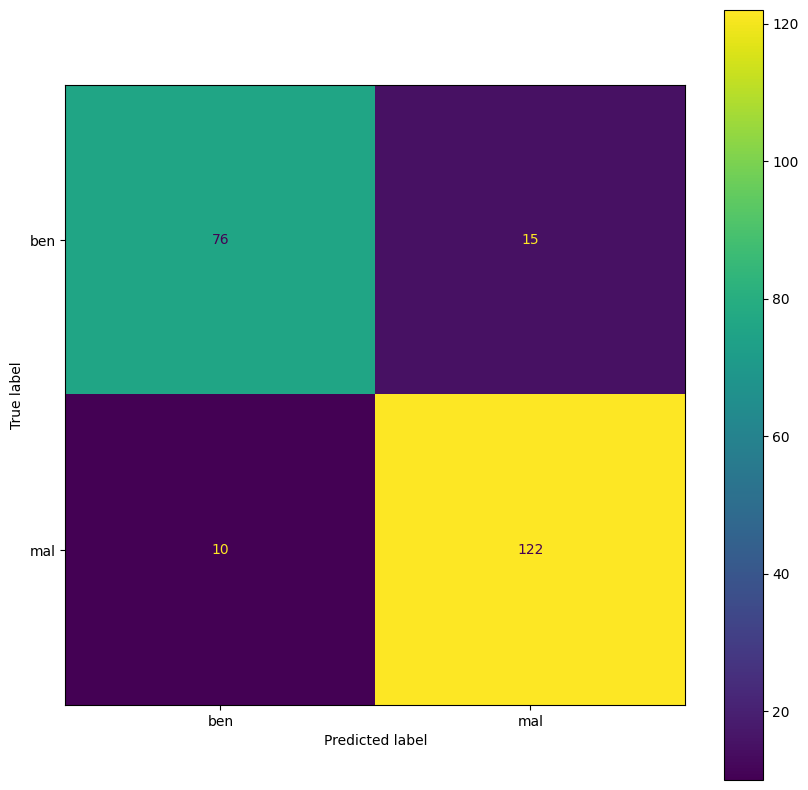

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, test_predictions_rf, labels=rf_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)


fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.show()

In [8]:

#save_features_labels(train_features, train_labels, 'train_features_labels_lbp_bi_train.pkl')

#save_features_labels(test_features, test_labels, 'test_features_labels_lbp_bi_test.pkl')



In [9]:
train_features = []
train_labels =[]
test_features = []
test_labels =[]
train_features, train_labels = load_features_labels('train_features_labels_lbp_multi_train.pkl')


test_features, test_labels = load_features_labels('test_features_labels_lbp_multi_test.pkl')

In [10]:
llista_etiquetades = []

for i in range(len(benignes)):
    llista_etiquetades.append([benignes[i],'ben'])

for i in range(len(benignes)):
    llista_etiquetades.append([proB[i],'proB'])
    llista_etiquetades.append([preB[i],'preB'])
    llista_etiquetades.append([early_preB[i],'early_preB'])

for i in range(4):
  print(llista_etiquetades[i][-1])
print(len(llista_etiquetades))

random.shuffle(llista_etiquetades)

paths, labels = zip(*llista_etiquetades)

train_paths, test_paths, train_labels, test_labels = train_test_split(paths, labels, test_size=0.2, random_state=42)

train = pd.DataFrame({'Path': train_paths, 'Label': train_labels})
test = pd.DataFrame({'Path': test_paths, 'Label': test_labels})

print("Number of training samples:", len(train))
print("Number of testing samples:", len(test))

print("Example training sample path:", train.iloc[0]['Path'])
print("Example training sample label:", train.iloc[0]['Label'])

print(test.shape)

ben
ben
ben
ben
2048
Number of training samples: 1638
Number of testing samples: 410
Example training sample path: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1F80E6ED090>
Example training sample label: proB
(410, 2)


#### Ara repetirem els mateixos classificadors més simples pero amb una classificació multiclasse per veure com es comporten.

In [11]:

if len(train_features) == 0 or len(train_labels) == 0:
  train_features = []
  train_labels = []

  for index, row in train.iterrows():
      image_path = row['Path'].filename
      label = row['Label']
      if os.path.exists(image_path):
          image = img_as_ubyte(io.imread(image_path))
          gray_image = color.rgb2gray(image)
          lbp_features = extract_lbp_features(gray_image)
          train_features.append(lbp_features)
          train_labels.append(label)
      else:
          print(f"Image not found at path: {image_path}")

#prova d'entrenament amb resultat amb només train
train_features = np.array(train_features)
train_labels = np.array(train_labels)
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# SVC
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Train Accuracy:", accuracy)

#Test
if len(test_features) == 0 or len(test_labels) == 0:
  test_features = []
  test_labels = []

  for index, row in test.iterrows():
      image_path = row['Path'].filename
      label = row['Label']
      if os.path.exists(image_path):
          image = img_as_ubyte(io.imread(image_path))
          gray_image = color.rgb2gray(image)
          lbp_features = extract_lbp_features(gray_image)
          test_features.append(lbp_features)
          test_labels.append(label)
      else:
          print("Error")


test_features = np.array(test_features)
test_labels = np.array(test_labels)
test_predictions = svm_classifier.predict(test_features)

test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

#RANDOM FOREST
# Crear y entrenar el clasificador Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_features, train_labels)

# Realizar predicciones en el conjunto de prueba
test_predictions_rf = rf_classifier.predict(test_features)

# Calcular y mostrar la precisión del Random Forest
test_accuracy_rf = accuracy_score(test_labels, test_predictions_rf)
print("Test Accuracy with Random Forest:", test_accuracy_rf)
print(classification_report(test_labels, test_predictions_rf))

Train Accuracy: 0.25914634146341464
Test Accuracy: 0.21707317073170732
Test Accuracy with Random Forest: 0.2707317073170732
              precision    recall  f1-score   support

         ben       0.23      0.29      0.26        89
  early_preB       0.30      0.24      0.26       110
        preB       0.32      0.26      0.29       120
        proB       0.25      0.31      0.27        91

    accuracy                           0.27       410
   macro avg       0.27      0.27      0.27       410
weighted avg       0.28      0.27      0.27       410



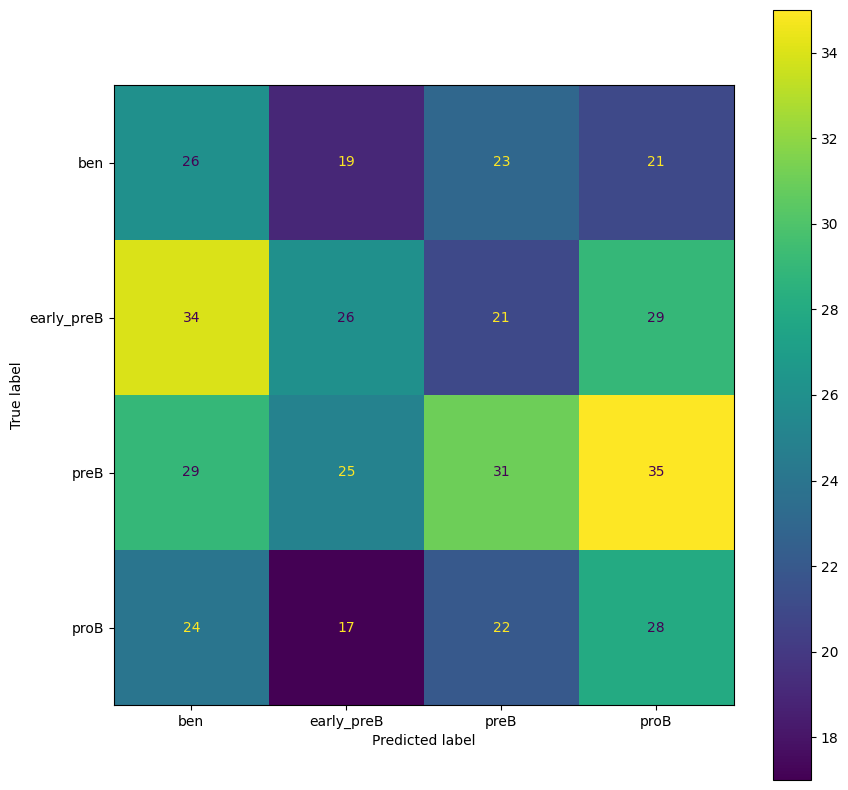

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, test_predictions_rf, labels=rf_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)


fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.show()

In [13]:



#save_features_labels(train_features, train_labels, 'train_features_labels_lbp_multi_train.pkl')




#save_features_labels(test_features, test_labels, 'test_features_labels_lbp_multi_test.pkl')



#### Ligth GBM

In [30]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd


train_features, train_labels = load_features_labels('train_features_labels_lbp_multi_train.pkl')


test_features, test_labels = load_features_labels('test_features_labels_lbp_multi_test.pkl')


label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)


lgb_train = lgb.Dataset(train_features, train_labels_encoded)
lgb_test = lgb.Dataset(test_features, test_labels_encoded, reference=lgb_train)

# Parametres
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(train_labels_encoded)),  #Nº de classes
    'metric': 'multi_logloss', #Metricac
    'verbosity': -1,  #logs
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Nº de fulles
    'learning_rate': 0.25,  # Learning rate
    'feature_fraction': 0.9,  # Selecció random del 90% de features per entrenar cada arbre
    'bagging_fraction': 0.8,  # Selecció random del 90% de dades per entrenar cada arbre
    'bagging_freq': 5,  # Fer bagging cada 5 iterations
    'seed': 42  # Random seed
}


num_round = 1000

bst = lgb.train(
    params,
    lgb_train,
    num_boost_round=num_round,
    valid_sets=[lgb_train, lgb_test],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)


lgb_pred = bst.predict(test_features, num_iteration=bst.best_iteration)
lgb_pred = [np.argmax(pred) for pred in lgb_pred]

test_accuracy_lgb = accuracy_score(test_labels_encoded, lgb_pred)
print("Test Accuracy with LightGBM:", test_accuracy_lgb)
print(classification_report(test_labels_encoded, lgb_pred))

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	training's multi_logloss: 0.00901791	valid_1's multi_logloss: 0.250906
Test Accuracy with LightGBM: 0.9219512195121952
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        97
           1       0.86      0.93      0.89       103
           2       0.98      0.95      0.96       113
           3       0.94      0.92      0.93        97

    accuracy                           0.92       410
   macro avg       0.92      0.92      0.92       410
weighted avg       0.92      0.92      0.92       410



In [14]:
train_features = []
train_labels =[]
test_features = []
test_labels = []
train_features, train_labels = load_features_labels('train_features_labels_hog_train.pkl')


test_features, test_labels = load_features_labels('test_features_labels_hog_test.pkl')

In [15]:
import os
import numpy as np
import pandas as pd
from skimage import io, color
from skimage.util import img_as_ubyte
from skimage.transform import resize
from skimage.feature import hog
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

def calculate_hog_features(image):

    if len(image.shape) == 2 or image.shape[2] == 1:
        # Imagen en escala de grises
        image = resize(image, (128, 64))
        fd = hog(image, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), visualize=False, channel_axis=None)
    else:
        # Imagen a color
        image = resize(image, (128, 64))
        fd = hog(image, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), visualize=False, channel_axis=-1)
    return fd


if len(train_features) == 0 or len(train_labels) == 0:
  train_features = []
  train_labels = []


  for index, row in train.iterrows():
      image_path = row['Path'].filename
      label = row['Label']
      if os.path.exists(image_path):
          image = img_as_ubyte(io.imread(image_path))

          hog_features = calculate_hog_features(image)
          train_features.append(hog_features)
          train_labels.append(label)
      else:
          print(f"Image not found at path: {image_path}")


train_features = np.array(train_features)
train_labels = np.array(train_labels)




svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_features, train_labels)
y_pred = svm_classifier.predict(train_features)

train_accuracy = accuracy_score(train_labels, y_pred)
print("Train Accuracy:", train_accuracy)


if len(test_features) == 0 or len(test_labels) == 0:
  test_features = []
  test_labels = []


  for index, row in test.iterrows():
      image_path = row['Path'].filename
      label = row['Label']
      if os.path.exists(image_path):
          image = img_as_ubyte(io.imread(image_path))

          hog_features = calculate_hog_features(image)
          test_features.append(hog_features)
          test_labels.append(label)
      else:
          print(f"Image not found at path: {image_path}")


test_features = np.array(test_features)
test_labels = np.array(test_labels)


y_pred = svm_classifier.predict(test_features)

test_accuracy = accuracy_score(test_labels, y_pred)
print("Test Accuracy:", test_accuracy)

#RANDOM FOREST

rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_features, train_labels)


test_predictions_rf = rf_classifier.predict(test_features)


test_accuracy_rf = accuracy_score(test_labels, test_predictions_rf)
print("Test Accuracy with Random Forest:", test_accuracy_rf)
print(classification_report(test_labels, test_predictions_rf))

Train Accuracy: 1.0
Test Accuracy: 0.526829268292683
Test Accuracy with Random Forest: 0.5975609756097561
              precision    recall  f1-score   support

         ben       0.48      0.40      0.44        97
  early_preB       0.62      0.62      0.62       103
        preB       0.61      0.54      0.57       113
        proB       0.65      0.84      0.73        97

    accuracy                           0.60       410
   macro avg       0.59      0.60      0.59       410
weighted avg       0.59      0.60      0.59       410



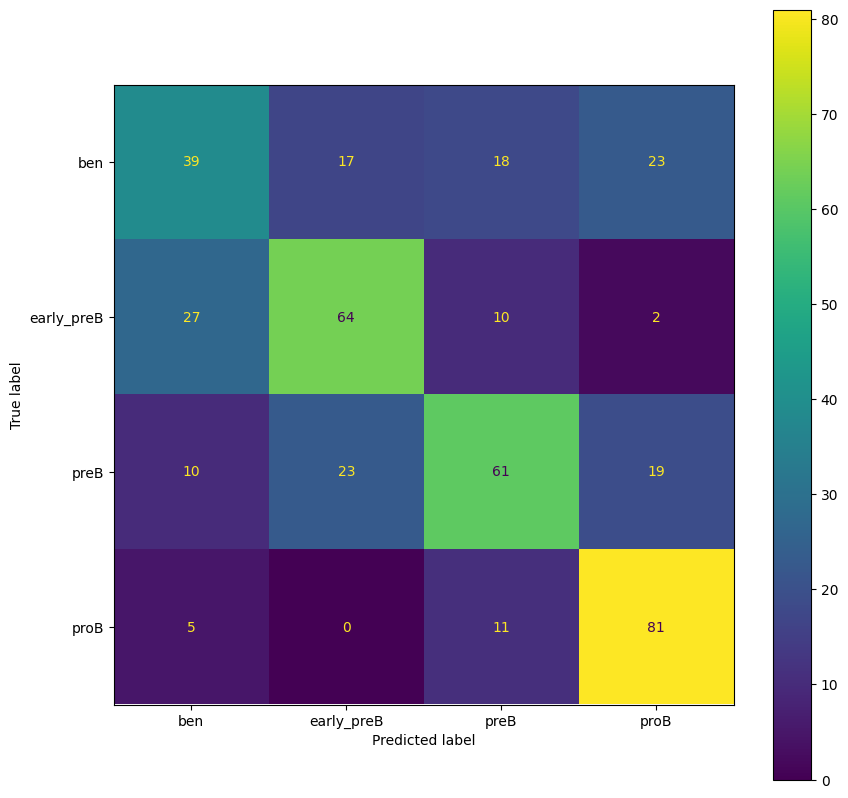

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, test_predictions_rf, labels=rf_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)


fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.show()

In [17]:

#save_features_labels(train_features, train_labels, 'train_features_labels_hog_train.pkl')



#save_features_labels(test_features, test_labels, 'test_features_labels_hog_test.pkl')



### Aqui tenim implementat el CNN, es fa no només la classificació entre benignes i malignes si no que tambe mirem quin tipus de malignes son, aquest algorisme si es pot consedirar eficient per a aquest tipus de problemes

#### Aquesta primera part carrega les imatges binaritzant-les per tal de detectar les celules cancerigenes i s'etiqueten

In [18]:
import os
import numpy as np
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def prepare_images(image_list, size=(64, 64)):
    processed_images = []
    for img in image_list:
        img = img.resize(size)
        img_array = np.array(img)
        if img_array.shape == (size[0], size[1], 3):
            processed_images.append(img_array / 255.0)
    return np.array(processed_images)


benignes = prepare_images(llegir_imatges(ruta_cel_benignes))
proB = prepare_images(llegir_imatges(ruta_cel_malignes_ProB))
preB = prepare_images(llegir_imatges(ruta_cel_malignes_PreB))
early_preB = prepare_images(llegir_imatges(ruta_cel_malignes_early_PreB))

images = np.concatenate([benignes, proB, preB, early_preB])

labels = ['benign'] * len(benignes) + ['proB'] * len(proB) + ['preB'] * len(preB) + ['early_preB'] * len(early_preB)


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels_categorical, test_size=0.2, random_state=42)

image_size = (64, 64)  # == prepare_images
num_classes = labels_categorical.shape[1]

#### Definim la xarxa neuronal, la compilem i evaluem els resultats obtinguts pel classificador, obtenim les epoques òptimer per realitzar la classificació

C:\Users\Admin\OneDrive - UAB\Escritorio\Python\Instalación de python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,716 (2.61 MB)

 Trainable params: 683,716 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.3981 - loss: 1.2452 - val_accuracy: 0.8015 - val_loss: 0.5806
Epoch 2/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7333 - loss: 0.6916 - val_accuracy: 0.7688 - val_loss: 0.6535
Epoch 3/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7463 - loss: 0.6357 - val_accuracy: 0.8324 - val_loss: 0.4293
Epoch 4/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7692 - loss: 0.5897 - val_accuracy: 0.8478 - val_loss: 0.4527
Epoch 5/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.7911 - loss: 0.5190 - val_accuracy: 0.8516 - val_loss: 0.3853
Epoch 6/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7946 - loss: 0.5151 - val_accuracy: 0.8651 - val_loss: 0.3767
Epoch 7/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8288 - loss: 0.4348 - val_accuracy: 0.8805 - val_loss: 0.3194
Epoch 8/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.8606 - loss: 0.3683 - val_accuracy: 0.8940 - v

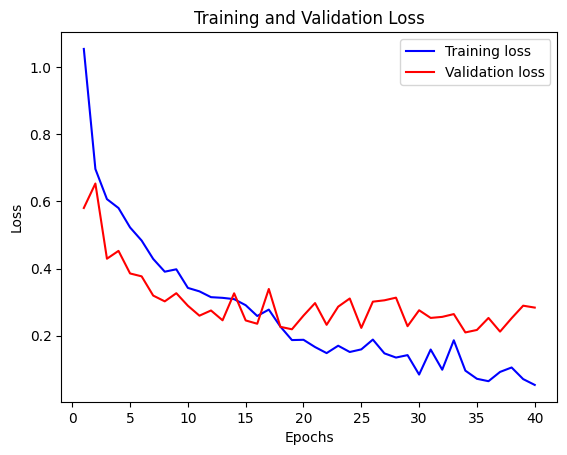

In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
epoca = 40
hist = model.fit(train_images, train_labels, epochs=epoca, batch_size=32, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Crear un rango de épocas
epochs_range = range(1, epoca + 1)

# Graficar la pérdida de entrenamiento y validación
plt.plot(epochs_range, train_loss, 'b', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Veient que el KNN es el que millors resultats aporta a la classificació multiclasse, ara miraren d'aplicar un data augmentation pertal d'intentar millorar encara més el classificador

In [40]:
import numpy as np
import tensorflow as tf
from functools import reduce


print('aawedwd')

labels_benign = np.full(len(benignes), 'benign')
labels_proB = np.full(len(proB), 'proB')
labels_preB = np.full(len(preB), 'preB')
labels_early_preB = np.full(len(early_preB), 'early_preB')


images = np.concatenate((benignes, proB, preB, early_preB), axis=0)
labels = np.concatenate((labels_benign, labels_proB, labels_preB, labels_early_preB))


dataset = tf.data.Dataset.from_tensor_slices((images, labels))


def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=3)
    return image, label


repeats = 15  # Número de veces que se duplicará el dataset
augmented_datasets = [dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE) for _ in range(repeats)]

augmented_dataset = reduce(lambda d1, d2: d1.concatenate(d2), augmented_datasets)


batch_size = 32
augmented_dataset = augmented_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


dataset_size = sum(1 for _ in augmented_dataset)
print(f'Tamaño del dataset final(porción): {dataset_size}')


aawedwd
Tamaño del dataset final(porción): 855


C:\Users\Admin\OneDrive - UAB\Escritorio\Python\Instalación de python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.4431 - loss: 1.2651 - val_accuracy: 0.4485 - val_loss: 1.2501
Epoch 2/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4644 - loss: 1.2347 - val_accuracy: 0.5422 - val_loss: 1.1240
Epoch 3/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6107 - loss: 0.9871 - val_accuracy: 0.6584 - val_loss: 0.8752
Epoch 4/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7383 - loss: 0.6959 - val_accuracy: 0.7531 - val_loss: 0.7233
Epoch 5/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8238 - loss: 0.4920 - val_accuracy: 0.8004 - val_loss: 0.6447
Epoch 6/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8795 - loss: 0.3478 - val_accuracy: 0.8509 - val_loss: 0.6103
Epoch 7/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9170 - loss: 0.2523 - val_accuracy: 0.8743 - val_loss: 0.6065
Epoch 8/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9387 - loss: 0.1976 - val_acc

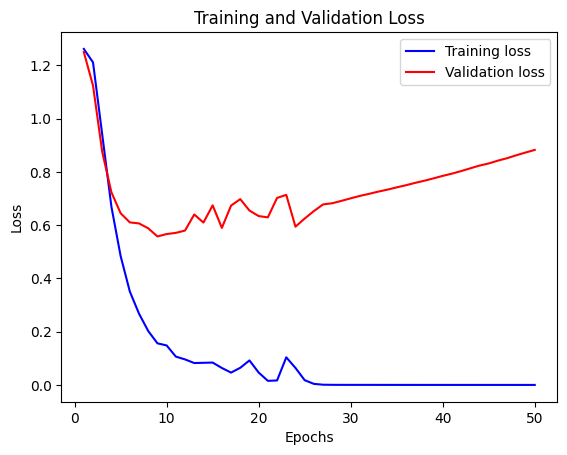

In [49]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


def dataset_to_numpy(dataset):
    images, labels = [], []
    for image, label in dataset:
        images.append(image.numpy())
        labels.append(label.numpy().decode('utf-8'))
    return np.array(images), np.array(labels)


augmented_images, augmented_labels = dataset_to_numpy(augmented_dataset.unbatch())


label_encoder = LabelEncoder()
augmented_labels_encoded = label_encoder.fit_transform(augmented_labels)


X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels_encoded, test_size=0.2, random_state=42)


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 clases
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


hist = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Precisión del modelo en el conjunto de prueba: {test_acc}')

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']


epochs_range = range(1, 51)


plt.plot(epochs_range, train_loss, 'b', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9461 - loss: 0.5369
Precisión del modelo en el conjunto de prueba: 0.9473684430122375


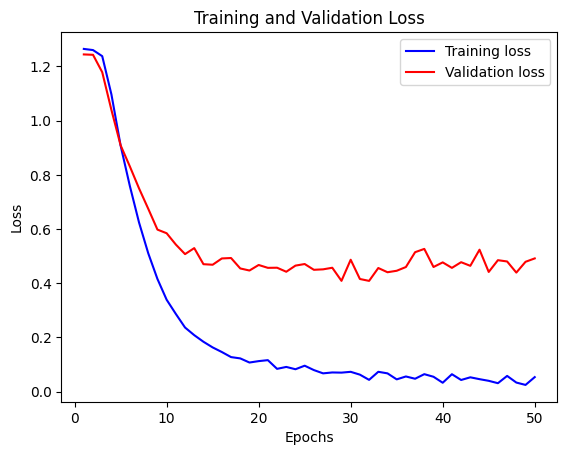

In [48]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Precisión del modelo en el conjunto de prueba: {test_acc}')

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']


epochs_range = range(1, 51)


plt.plot(epochs_range, train_loss, 'b', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()